# Quantum superdense coding demonstration
## Ben Bartlett

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

%matplotlib inline

In [36]:
def isHermitian(matrix): 
    '''
    Checks if an operator is Hermitian
    :param matrix: the operator to check
    :return: true or false
    '''
    return np.array_equal(matrix.conj().T, matrix)

In [37]:
def tensorProd(state1, state2):
    if len(state1) == 0:
        return state2
    elif len(state2) == 0:
        return state1
    else:
        return np.kron(state1, state2)

def tensors(operatorList):
    result = []
    for operator in operatorList:
        result = tensorProd(result, operator)
    return result

def tensorFillIdentity(singleQubitOperator, nQubits, qubitIndex):
    '''
    Create the n-qubit operator I x I x ... Operator x I x I... with operator applied to a given
    qubit index
    :param singleQubitOperator: the operator in the computational basis (a 2x2 matrix)
    :param nQubits: the number of qubits in the system to fill
    :param qubitIndex: the zero-indexed qubit to apply this operator to
    :return: the n-qubit operator
    '''
    assert 0 <= qubitIndex <= nQubits - 1, "qubit Index is out of range"
    operator = tensors([
        tensors([np.eye(2)] * qubitIndex),
        singleQubitOperator,
        tensors([np.eye(2)] * (nQubits - (qubitIndex + 1)))
    ])
    return operator

In [113]:
tensorFillIdentity([[1, 0], [0, -1]], 2, 0)

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0., -1., -0.],
       [ 0.,  0., -0., -1.]])

In [38]:
class Qubit:
    '''
    Simple qubit implementation. 
    Retains a reference to a quantum system that can deal with multi-particle dynamics
    '''

    def __init__(self, initialState=np.array([1, 0])):
        self.initialState = initialState  # start off in the |0> state by default
        self.index = 0  # the index/qubit number in the quantum system object
        self.qSystem = QSystem([self])  # the overall quantum state of the system of qubits

    def entangle(self, qSystem):
        '''
        Entangle this qubit with another set of ones.
        This doesn't actually perform any entanglement, it just links the quantum systems
        together, allowing multi-particle gates like CNOT to be applied.
        :param qSystem: the state of 1+ qubits with which to entangle this one
        :return: nothing
        '''
        qSystem.addQubit(self)  # add this to the quantum system
        self.qSystem = qSystem  # change the quantum system object

    def measure(self):
        '''
        Perform a measurement in the computational (z) basis on this qubit and update the 
        :return: 0 or 1, depending on the outcome of the measurement
        '''
        return self.qSystem.measureQubit(self.index)

    def apply(self, operator):
        '''
        Apply a single-qubit operator to this qubit, updating the overall qSystem
        :param operator: single-qubit operator to apply
        :return: nothing, the qSystem state is mutated
        '''
        self.qSystem.apply(operator, index=self.index)
    

class QSystem:
    '''
    Maintains a multi-particle Hilbert space for several qubits
    '''

    def __init__(self, qubitList):
        '''
        Instantiate a new quantum system object form a list of existing qubits
        :param qubitList: list of qubits to create the state from
        '''
        self.qubits = qubitList
        self.state = []
        for i, qubit in enumerate(qubitList):
            self.state = tensorProd(self.state, qubit.initialState)
            qubit.index = i

    def addQubit(self, newQubit):
        newQubit.index = len(self.qubits)  # zero indexed, so length is next index
        self.qubits.append(newQubit)
        # TODO: at the moment you can't make modifications to qubits then entangle them
        self.state = tensorProd(self.state, newQubit.initialState)

    def measureQubit(self, qubitIndex):
        '''
        Measure the qubit at a given index, partially collapsing the state based 
        on the observed value of the measured qubit
        :param qubitIndex: the qubit to measure 
        :return: the measured qubit value
        '''
        # Generate measurement operators for the n-qubit state
        M0 = np.outer([1, 0], [1, 0])
        M1 = np.outer([0, 1], [0, 1])
        measure0 = tensorFillIdentity(M0, len(self.qubits), qubitIndex)
        measure1 = tensorFillIdentity(M1, len(self.qubits), qubitIndex)
        prob0 = np.linalg.multi_dot([
            self.state.conj().T,
            measure0.conj().T,
            measure0,
            self.state
        ])
        prob1 = np.linalg.multi_dot([
            self.state.conj().T,
            measure1.conj().T,
            measure1,
            self.state
        ])
        # Perform the measurement and collapse the state matrix accordingly
        if (np.random.rand() / (prob0 + prob1)) > prob0:
            # qubit collapses to 1
            self.state = np.dot(measure1, self.state) / np.sqrt(prob1)
            return 1
        else:
            #qubit collapses to 0
            self.state = np.dot(measure0, self.state) / np.sqrt(prob0)
            return 0

    def apply(self, operator, index=None):
        '''
        Apply an operator to this quantum state. If no index is specified, an n-qubit
        operator is assumed, else a single-qubit operation is applied to the specified
        qubit
        :param operator: the single- or n-qubit operator to apply
        :param index: if specified, the index of the qubit to perform the oepration on
        :return: nothing, the qSystem state is mutated
        '''
        # Expand the operator to n qubits if needed
        if index is not None:
            operator = tensorFillIdentity(operator, len(self.qubits), index)
        # Apply the operator
        assert isHermitian(operator), "Qubit operators must be Hermitian"
        self.state = np.dot(operator, self.state)

In [39]:
# Single qubit gates 

def Hadamard(qubit):
    '''
    Implements the Hadamard transform on a given qubit, updating the qSystem
    :param qubit: the qubit to apply the operator to
    :return: nothing - the qSystem is mutated by this function
    '''
    hadamardMatrix = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])
    qubit.apply(hadamardMatrix)

def PauliX(qubit):
    xMatrix = np.array([[0, 1], [1, 0]])
    qubit.apply(xMatrix)

def PauliY(qubit):
    yMatrix = np.array([[0, -1j], [1j, 0]])
    qubit.apply(yMatrix)

def PauliZ(qubit):
    zMatrix = np.array([[1, 0], [0, -1]])
    qubit.apply(zMatrix)


# Some two-qubit operators as matrices; must be applied with qSystem.apply()

CNOT = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0],
])

## Quantum superdense coding

![Superdense coding diagram](https://upload.wikimedia.org/wikipedia/commons/b/b7/Superdense_coding.png)

In [51]:
def transmitTwoBits(bit1, bit2):
    # Prepare a two-qubit system
    alice = Qubit()
    bob = Qubit()
    bob.entangle(alice.qSystem)

    # Prepare and share a Bell pair
    Hadamard(alice)
    alice.qSystem.apply(CNOT)

    # Alice encodes her bits
    if bit2 == 1:
        PauliX(alice)
    if bit1 == 1:
        PauliZ(alice)

    # Alice sends her qubit to bob and then he decodes the bits
    bob.qSystem.apply(CNOT)
    Hadamard(alice)

    # Measure the results
    outputBit1 = alice.measure()
    outputBit2 = bob.measure()
    return outputBit1, outputBit2

def transmitByte(byteChar):
    value = ord(byteChar)
    bits = np.unpackbits(np.array([value], dtype=np.uint8))
    receivedBits = np.zeros(8, dtype=np.uint8)
    for i in range(4):
        b1, b2 = transmitTwoBits(bits[2 * i], bits[2 * i + 1])
        receivedBits[2 * i] = b1
        receivedBits[2 * i + 1] = b2
    receivedValue = np.packbits(receivedBits)[0]
    return chr(receivedValue)


In [54]:
transmitByte('1')

'1'

## Incorporating fiber optic losses

Let's simulate some of the losses that occur over fiber optic cables and see how this affects transmission fidelity. 

In [109]:
fiberOpticAttenuation = -0.16  # dB/km, from Yin, et al, Satellite-based entanglement
cableLength = 1  # km, let's just call it this for now 
# Total attenuation along the fiber, equal to probability of receiving a photon
decibelLoss = cableLength * fiberOpticAttenuation
cableAttenuation = 10 ** (decibelLoss / 10)
    
def attenuatedSuperdenseTransmission(bit1, bit2):
    # Alice prepares a two-qubit system
    alice = Qubit()
    bob = Qubit()
    bob.entangle(alice.qSystem)
    Hadamard(alice)
    alice.qSystem.apply(CNOT)

    # Alice sends the first qubit to Bob - if it is attenuated, return 0,0
    if np.random.rand() > cableAttenuation:
        return 0,0

    # Alice encodes her bits
    if bit2 == 1:
        PauliX(alice)
    if bit1 == 1:
        PauliZ(alice)

    # Alice sends her qubit to bob and then he decodes the bits
    if np.random.rand() > cableAttenuation:
        return 0,0 
    bob.qSystem.apply(CNOT)
    Hadamard(alice)

    # Measure the results
    outputBit1 = alice.measure()
    outputBit2 = bob.measure()
    return outputBit1, outputBit2

def attenuatedIntTransmission(value):
    '''Transmit an 8-bit unsigned integer value including attenuation effects'''
    bits = np.unpackbits(np.array([value], dtype = np.uint8))
    receivedBits = np.zeros(8, dtype = np.uint8)
    for i in range(4):
        b1, b2 = attenuatedSuperdenseTransmission(bits[2*i], bits[2*i+1]) 
        receivedBits[2*i] = b1
        receivedBits[2*i+1] = b2 
    return np.packbits(receivedBits)[0]

def attenuatedArrayTransmission(array):
    receivedArray = np.zeros(array.shape, dtype = np.uint8)
    iterator = np.nditer(array, flags=['multi_index'])
    while not iterator.finished:
        receivedElement = attenuatedIntTransmission(iterator[0])
        receivedArray[iterator.multi_index] = receivedElement
        iterator.iternext()
    return receivedArray

Original image:


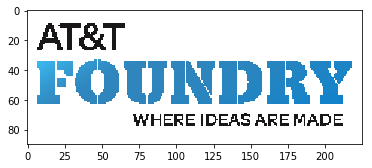

In [110]:
# Let's try transmitting the following image: 
imgData = mp.image.imread("img/foundryLogo.bmp") 
print "Original image:"
plt.imshow(imgData)

Reconstructed transmitted image accounting for attenuation effects:


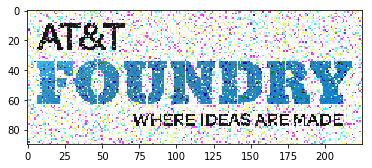

In [111]:
# Transmit the image with the attenuated superdense protocol
receivedArray = attenuatedArrayTransmission(imgData)
print "Reconstructed transmitted image accounting for attenuation effects:"
plt.imshow(receivedArray)

## Testing area for QStream class

In [14]:
from squanch import qstream
from squanch import gates

In [15]:
qs = qstream.QStream(2,100)

In [16]:
qs.system(0).apply(gates.H, 0)

TypeError: 'numpy.float64' object cannot be interpreted as an index

In [12]:
gates.H

array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]])